In [1]:
!pip install torchsummary

In [2]:
import torch
import os
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.torch_version
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
main_path = '/kaggle/input/isic-2024-challenge' if iskaggle else 'data/isic-2024-challenge'

In [5]:
train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv' if iskaggle else 'data/isic-2024-challenge/train-metadata.csv'
test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv' if iskaggle else 'data/isic-2024-challenge/test-metadata.csv'

train_metadata_df = pd.read_csv(train_metadata_path)
test_metadata_df = pd.read_csv(test_metadata_path)

print(len(train_metadata_df))

/tmp/ipykernel_34/3275392473.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv(train_metadata_path)


401059


In [6]:
import sklearn.model_selection as train_test_split

train_size = 0.8
# Splitting the train dataset into positive and negative samples and saving them in separate dataframes
postive_samples = train_metadata_df[train_metadata_df['target'] == 1]
negative_samples = train_metadata_df[train_metadata_df['target'] == 0]
print(f"Positive samples: {postive_samples.shape}")
print(f"Negative samples: {negative_samples.shape}")

Positive samples: (393, 55)
Negative samples: (400666, 55)


In [7]:

# Splitting each type of samples into train and validation sets
train_positive_samples, val_positive_samples = train_test_split.train_test_split(postive_samples,test_size=1-train_size)
train_negative_samples, val_negative_samples = train_test_split.train_test_split(negative_samples,test_size=1-train_size)
print(f"Train positive samples: {train_positive_samples.shape}")
print(f"Train negative samples: {train_negative_samples.shape}")
print(f"Val positive samples: {val_positive_samples.shape}")
print(f"Val negative samples: {val_negative_samples.shape}")


Train positive samples: (314, 55)
Train negative samples: (320532, 55)
Val positive samples: (79, 55)
Val negative samples: (80134, 55)


In [8]:

# Concatenating the positive and negative samples to get the train and validation sets
train_metadata_df = pd.concat([train_positive_samples, train_negative_samples])
val_metadata_df = pd.concat([val_positive_samples, val_negative_samples])
print(f"Train samples: {train_metadata_df.shape}")
print(f"Val samples: {val_metadata_df.shape}")
print(f"Test samples: {test_metadata_df.shape}")


Train samples: (320846, 55)
Val samples: (80213, 55)
Test samples: (3, 44)


In [9]:
import h5py
from io import BytesIO

train_hdf5_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5' if iskaggle else 'data/isic-2024-challenge/train-image.hdf5'
test_hdf5_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5' if iskaggle else 'data/isic-2024-challenge/test-image.hdf5'
train_image_path = '/kaggle/input/isic-2024-challenge/train-image/image' if iskaggle else 'data/isic-2024-challenge/train-image/image'

In [10]:
class CustomDataset(Dataset):
    def __init__(self, hdf5_file_path, metadata_df,target=None, transform=None):
        self.hdf5_file = h5py.File(hdf5_file_path,'r')
        self.metadata_df = metadata_df
        self.image_ids = metadata_df['isic_id']
        self.labels = target
        self.transform = transform

        self.mean_of_color_channels = None  # Initialize as None
        self.std_of_color_channels = None   # Initialize as None
        # self._calculate_stats()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids.iloc[idx]
        image = np.array(Image.open(BytesIO(self.hdf5_file[image_id][()])),dtype=np.float32)/255
        
        # Calculate mean and standard deviation if not already done
        # if self.mean_of_color_channels is None or self.std_of_color_channels is None:
        #     self._calculate_stats()

        # Apply transformation with calculated statistics
        if self.transform:
            image = self.transform(image=image)
            image = image['image']

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return image, label
        else:
            return image
   

In [22]:
# HyperParameters
dim = 50 
batch_size = 64

In [23]:
train_transform = A.Compose([
    A.Resize(height=dim, width=dim), #resize 
    A.OneOf([A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
             A.RandomBrightnessContrast() 
             ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # !!One needs to change the mean and std values to appropriate ones for this dataset.!!
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])


test_transform = A.Compose([
    A.Resize(height=dim, width=dim), #resize 
    # !!One needs to change the mean and std values to appropriate ones for this dataset.!!
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])

In [24]:
train_dataset = CustomDataset(train_hdf5_path,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
# train_image_dataset = CustomDatasetImage(train_image_path,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
val_dataset = CustomDataset(train_hdf5_path,val_metadata_df,target=val_metadata_df['target'],transform=train_transform)
test_dataset = CustomDataset(test_hdf5_path,test_metadata_df,transform=test_transform)

In [25]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)

In [26]:
from sklearn.metrics import roc_curve, auc

def calculate_partial_auc_by_tpr(y_true, y_scores, max_tpr=0.8):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Limit the TPR to the specified maximum
    mask = tpr <= max_tpr
    fpr, tpr = fpr[mask], tpr[mask]
    
    # Calculate the partial AUC
    partial_auc = auc(fpr, tpr)
    
    # Normalize the partial AUC to the range [0, 1]
    partial_auc /= max_tpr
    
    return partial_auc

In [29]:
class Model(nn.Module):
    def __init__(self,num_classes,device,dim = 32,num_epochs = 20,learning_rate = 0.001,early_stopping = False):
        super().__init__()
        self.num_of_classes = num_classes
        self.device = device
        self.dim = dim
        # Debugging
        self.DEBUG = True
        # Hyperparameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        # History while Training
        self.model_loss_history = []
        self.model_train_acc_history = []
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_val_pauc_history = []
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.BCELoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'binary', average='macro').to(self.device)
        self.precision = Precision(task= 'binary', average='macro').to(self.device)
        self.recall = Recall(task= 'binary', average='macro').to(self.device)
        # Feature Extraction
        self.feature_extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(4608, 512),  # Adjust the size based on the input image size
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(self.device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns accuracy, precision and recall
        '''
        self.eval()
        y_pred = []
        y_actual = []
        with torch.no_grad():
            for images, labels in data_loader:
                
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                labels = labels.unsqueeze(1).float()
                self.accuracy(outputs, labels)
                self.precision(outputs, labels)
                self.recall(outputs, labels)

                y_pred.extend(outputs.cpu().numpy())
                y_actual.extend(labels.cpu().numpy())
        
        partial_auc = calculate_partial_auc_by_tpr(y_actual, y_pred)


        return self.accuracy.compute(), self.precision.compute(), self.recall.compute(), partial_auc, y_pred, y_actual
    
    def train_model(self, train_loader, val_loader):
        
        last_accuracy = -100
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):
                
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self(images)
                labels = labels.unsqueeze(1).float()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%1000 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall, val_pauc, _ , _ = self.eval_val(val_loader)
            train_acc, _, _, _, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_val_pauc_history.append(val_pauc)
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val PAUC: {val_pauc}')
            
            if val_acc > last_accuracy:
                last_accuracy = val_acc
            elif self.early_stopping:
                break
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        axs[1, 2].plot(self.model_val_pauc_history)
        axs[1, 2].set_title('Model Partial AUC')
        axs[1, 2].set_xlabel('Epochs')
        axs[1, 2].set_ylabel('Partial AUC')
        

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(),type(self).__name__+'.pth')

    def print_summary(self):
        summary(self, (3, self.dim, self.dim))

In [30]:
num_of_classes = 2
cnn = Model(num_classes=num_of_classes, 
            device=device, 
            dim=dim, 
            num_epochs=2, 
            learning_rate=0.001,
            early_stopping=False)
cnn.to(device)
cnn.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           2,432
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
              ReLU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 512]       2,359,808
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [31]:
cnn.train_model(train_loader=train_loader,val_loader=val_loader)

 Step [0/5014] Loss: 0.7072963714599609
 Step [1000/5014] Loss: 6.797133091877757e-26
 Step [2000/5014] Loss: 3.706628060040629e-11
 Step [3000/5014] Loss: 1.0432126951864009e-26
 Step [4000/5014] Loss: 9.598236281992373e-21
 Step [5000/5014] Loss: 1.1886155526441773e-26
Epoch: 1/2, Loss: 1.897358850699449e-26,Train Acc: 0.9990200996398926, Val Acc: 0.9990150928497314, Val Precision: 0.0, Val Recall: 0.0, Val PAUC: 0.022159086062490906
 Step [0/5014] Loss: 1.0067561517110698e-21
 Step [1000/5014] Loss: 7.228132419414567e-23
 Step [2000/5014] Loss: 6.037109846058649e-20
 Step [3000/5014] Loss: 3.3336771898062107e-26
 Step [4000/5014] Loss: 5.699572302256781e-25
 Step [5000/5014] Loss: 1.6838462511303957e-26
Epoch: 2/2, Loss: 1.4081705802281907e-25,Train Acc: 0.9990200996398926, Val Acc: 0.9990192651748657, Val Precision: 0.0, Val Recall: 0.0, Val PAUC: 0.015403787263927859
Finished Training


In [32]:
cnn_acc , cnn_precision, cnn_recall , cnn_pauc, y_pred, y_actual = cnn.eval_val(val_loader)
print(f"Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}")

Accuracy: 0.9990196228027344, Precision: 0.0, Recall: 0.0


In [41]:
print(f"Partial AUC: {cnn_pauc}")
print(y_actual[0])

Partial AUC: 0.021529997380969154
[0.]


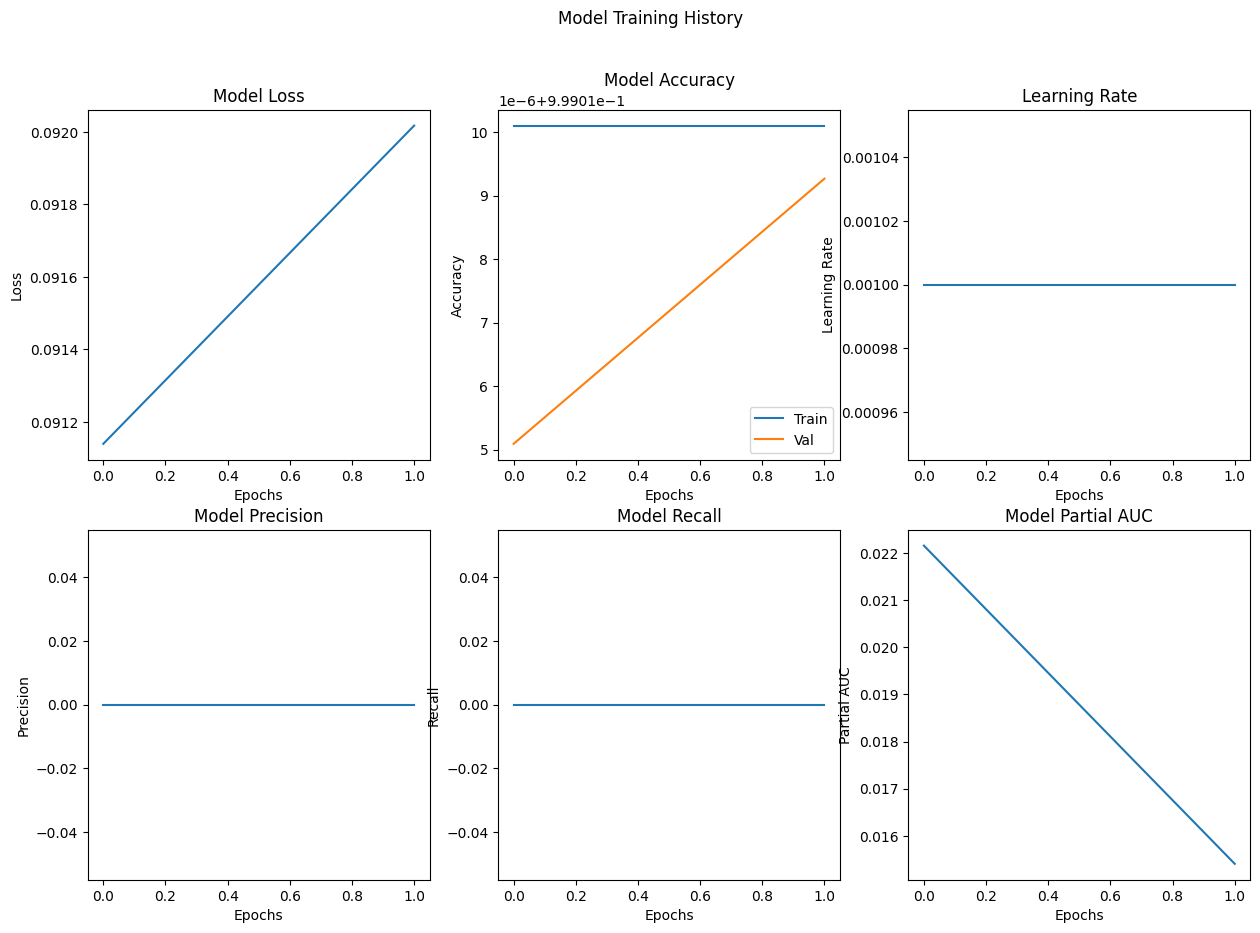

In [34]:
cnn.plot_history()

In [ ]:
cnn.save_model()